In [1]:
import copy
import os
import pathlib

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
from drmdp import dataproc

In [4]:
files = tf.io.gfile.glob(f"{pathlib.Path.home()}/fs/drmdp/workflows/controljob/agg/1746115037/1746166333/metrics/*.parquet")

In [5]:
df_metrics = dataproc.read_data(files, reader="pd")

In [6]:
df_metrics.iloc[0]["meta"]["env_spec"]

{'args': {'constraint_violation_reward': 0.0,
  'max_episode_steps': 200.0,
  'penalty_gamma': 1.0,
  'reward_fn': 'pos-enf'},
 'feats_spec': {'args': None, 'name': 'scale'},
 'name': 'Finite-SC-ShuntDc-v0'}

In [7]:
df_metrics

,episode,exp_id,meta,returns,metrics,method
0,710,1746115037-00b9abcd-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[102.02783073563408, 104.33277137208779, 301.7...","{'returns': {'mean': 160.70075962951634, 'std'...",IMR
1,710,1746115037-01241eab-Finite-SC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[141.96122545991437, 158.30323632080845, 160.0...","{'returns': {'mean': 138.1951380766256, 'std':...",DMR
2,710,1746115037-19ac5573-Finite-SC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[14.36361851327176, 14.135411317837095, 14.485...","{'returns': {'mean': 94.14181259366002, 'std':...",DMR
3,710,1746115037-18a93f64-Finite-CC-ShuntDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[373.72272162757696, 372.6428221199749, 368.10...","{'returns': {'mean': 371.2849843573612, 'std':...",IMR
4,710,1746115037-0a19b809-Finite-TC-PermExDc-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[53.40493990335529, 50.018484348888315, 52.417...","{'returns': {'mean': 50.97578817325536, 'std':...",OP-S
...,...,...,...,...,...,...
6619,18350,1746115037-c693da3d-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-14.94479864857501, -15.733856465587706, -15....","{'returns': {'mean': -15.350051768296005, 'std...",IMR
6620,18350,1746115037-cc958b03-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-14.06353877172906, -13.963707699852868, -13....","{'returns': {'mean': -14.053504804461154, 'std...",L-TRACE-Bayes
6621,18350,1746115037-d1dd8368-IceWorld-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-33.336984360525314, -33.40777069369517, -33....","{'returns': {'mean': -33.382703939839786, 'std...",OP-A
6622,18350,1746115037-f1d39cc9-RedGreen-v0,"{'context': {'dummy': 0}, 'exp_id': '174611503...","[-12.8272028772274, -12.672824369244182, -10.2...","{'returns': {'mean': -11.906962381704904, 'std...",OP-A


In [8]:
envs = dataproc.get_distinct_envs(df_metrics)

In [9]:
for env_name, spec in sorted(envs.items()):
    print(env_name, spec)

Finite-CC-PermExDc-v0 {'constraint_violation_reward': 0.0, 'max_episode_steps': 200.0, 'penalty_gamma': 1.0, 'reward_fn': 'pos-enf'}
Finite-CC-ShuntDc-v0 {'constraint_violation_reward': 0.0, 'max_episode_steps': 200.0, 'penalty_gamma': 1.0, 'reward_fn': 'pos-enf'}
Finite-SC-PermExDc-v0 {'constraint_violation_reward': 0.0, 'max_episode_steps': 200.0, 'penalty_gamma': 1.0, 'reward_fn': 'pos-enf'}
Finite-SC-ShuntDc-v0 {'constraint_violation_reward': 0.0, 'max_episode_steps': 200.0, 'penalty_gamma': 1.0, 'reward_fn': 'pos-enf'}
Finite-TC-PermExDc-v0 {'constraint_violation_reward': 0.0, 'max_episode_steps': 200.0, 'penalty_gamma': 1.0, 'reward_fn': 'pos-enf'}
GridWorld-v0 {'max_episode_steps': 200.0}
IceWorld-v0 None
MountainCar-v0 {'max_episode_steps': 2500.0}
RedGreen-v0 None


In [10]:
def parse_delay_config(df_input: pd.DataFrame):
    df = copy.deepcopy(df_input)
    def parse_mu(delay_config):
        if delay_config is None:
            return None
        args = delay_config["args"]
        try:
            return args["delay"]
        except KeyError:
            return args["lam"]
        except KeyError as exc:
            raise ValueError(f"Unknown delay config {args}") from exc
    df["delay_type"] = df["delay_config"].apply(lambda dc: dc["name"] if dc else None)
    df["delay_mu"] = df["delay_config"].apply(parse_mu)
    del df["delay_config"]
    return df

In [11]:
def create_returns_plotting_data(
    df_data: pd.DataFrame,
):
    df_result = copy.deepcopy(df_data)
    for key in ("delay_config", "gamma",):
        df_result[key] = df_result["meta"].apply(lambda meta: meta["problem_spec"][key])

    specs = {
        "env": df_result["meta"].apply(lambda meta: meta["env_spec"]),
        "feats": df_result["meta"].apply(lambda meta: meta["env_spec"]["feats_spec"])
    }

    for prefix, col_fam in specs.items():
        for col in ("name", "args"):
            df_result[f"{prefix}_{col}"] = col_fam.apply(lambda spec: spec[col])                                       

    del df_result["meta"]

    df_result = parse_delay_config(df_result)
    df_baseline = df_result[pd.isnull(df_result["delay_type"])]
    df_result = df_result[~pd.isnull(df_result["delay_type"])]
    baseline_dfs = []
    distinct_algo_configs = df_result[["delay_type", "delay_mu"]].drop_duplicates()

    # Replicate baseline results for each config
    # to make plotting easier.
    for row in distinct_algo_configs.to_dict("records"):
        print(row)
        df_baseline_rp = copy.deepcopy(df_baseline)
        # reward period is one
        df_baseline_rp["delay_type"] = row["delay_type"]
        df_baseline_rp["delay_mu"] = row["delay_mu"]
        baseline_dfs.append(df_baseline_rp)
    df_result = pd.concat(baseline_dfs + [df_result], axis=0)
    df_result = df_result.sort_values(["method", "delay_type", "delay_mu"])
    
    # agg returns
    df_result["mean_returns"] = df_result["returns"].apply(lambda returns: np.mean(returns))
    return {"sarsa": df_result}

In [12]:
df_returns_curves = create_returns_plotting_data(df_metrics)

{'delay_type': 'fixed', 'delay_mu': 8.0}
{'delay_type': 'fixed', 'delay_mu': 6.0}
{'delay_type': 'fixed', 'delay_mu': 4.0}
{'delay_type': 'fixed', 'delay_mu': 2.0}


In [13]:
df_returns_curves["sarsa"]

,episode,exp_id,returns,metrics,method,gamma,env_name,env_args,feats_name,feats_args,delay_type,delay_mu,mean_returns
22,710,1746115037-13a371a6-GridWorld-v0,"[-116.80450070323488, -91.73558368495077, -86....","{'returns': {'mean': -102.15405532114393, 'std...",DMR,1.00,GridWorld-v0,"{'constraint_violation_reward': None, 'max_epi...",tiles,{'tiling_dim': 8.0},fixed,2.0,-102.154055
53,710,1746115037-210c9572-Finite-CC-ShuntDc-v0,"[334.0055588459358, 372.69036211208504, 373.40...","{'returns': {'mean': 357.6449037627348, 'std':...",DMR,1.00,Finite-CC-ShuntDc-v0,"{'constraint_violation_reward': 0.0, 'max_epis...",tiles,{'tiling_dim': 3.0},fixed,2.0,357.644904
54,710,1746115037-21518c65-Finite-TC-PermExDc-v0,"[281.6954143008865, 293.2259638826478, 336.105...","{'returns': {'mean': 293.8548534342618, 'std':...",DMR,1.00,Finite-TC-PermExDc-v0,"{'constraint_violation_reward': 0.0, 'max_epis...",tiles,{'tiling_dim': 3.0},fixed,2.0,293.854853
61,710,1746115037-319edc3e-GridWorld-v0,"[-114.29535864978902, -85.34599156118144, -82....","{'returns': {'mean': -103.99184247538679, 'std...",DMR,0.99,GridWorld-v0,"{'constraint_violation_reward': None, 'max_epi...",tiles,{'tiling_dim': 8.0},fixed,2.0,-103.991842
94,710,1746115037-4d54d728-Finite-SC-PermExDc-v0,"[182.86411430927123, 161.149824808921, 190.735...","{'returns': {'mean': 177.44930852696496, 'std'...",DMR,1.00,Finite-SC-PermExDc-v0,"{'constraint_violation_reward': 0.0, 'max_epis...",spliced-tiles,{'tiling_dim': 3.0},fixed,2.0,177.449309
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6490,18340,1746115037-d6bb89d1-RedGreen-v0,"[-437.10621013030914, -434.5109317921596, -433...","{'returns': {'mean': -433.4579321374698, 'std'...",OP-S,1.00,RedGreen-v0,None,tiles,{'tiling_dim': 6},fixed,8.0,-433.457932
6556,18350,1746115037-0238a0d3-IceWorld-v0,"[-58.79483406898807, -57.23197645904855, -63.3...","{'returns': {'mean': -61.98553394002143, 'std'...",OP-S,0.99,IceWorld-v0,None,tiles,{'tiling_dim': 6},fixed,8.0,-61.985534
6572,18350,1746115037-9e4568b4-IceWorld-v0,"[-183.48951010844095, -183.48166312462536, -18...","{'returns': {'mean': -185.01300928196466, 'std...",OP-S,1.00,IceWorld-v0,None,tiles,{'tiling_dim': 6},fixed,8.0,-185.013009
6581,18350,1746115037-c0825e58-RedGreen-v0,"[-244.61833142608032, -278.71216827420847, -29...","{'returns': {'mean': -285.6071385755544, 'std'...",OP-S,0.99,RedGreen-v0,None,tiles,{'tiling_dim': 6},fixed,8.0,-285.607139


In [14]:
df_returns_curves["sarsa"]["method"].unique()

array(['DMR', 'FR', 'IMR', 'L-TRACE', 'L-TRACE-Bayes', 'OP-A', 'OP-S'],
      dtype=object)

In [15]:
def export_figure(
    figure, name: str, format: str = "pdf", dpi=300, transparent: bool = True
):
    # to be able to save, we must plot
    base_dir = os.path.dirname(name)
    if not os.path.exists(base_dir):
        tf.io.gfile.makedirs(base_dir)
    figure.savefig(f"{name}.{format}", dpi=dpi, format=format, transparent=transparent)

In [16]:
MARKERS = ["s", "p", "o", "P", "X", "d"]

In [17]:
DASHES = {
    "FR": (1, 0),
    "DMR": (1, 1),
    "IMR": (1, 2),
    "L-TRACE": (2, 1),
    "L-TRACE-Bayes": (2, 2),
    "OP-A": (6, 2),
    "OP-S": (6, 3),
}

In [18]:
METHODS_PALETTES = {
    key: palette for key, palette in zip(
        ["FR", "DMR", "IMR", "L-TRACE", "L-TRACE-Bayes", "OP-A", "OP-S"],
        sns.color_palette()
    )
}

In [19]:
sorted(df_returns_curves["sarsa"]["env_name"].unique())

['Finite-CC-PermExDc-v0',
 'Finite-CC-ShuntDc-v0',
 'Finite-SC-PermExDc-v0',
 'Finite-SC-ShuntDc-v0',
 'Finite-TC-PermExDc-v0',
 'GridWorld-v0',
 'IceWorld-v0',
 'MountainCar-v0',
 'RedGreen-v0']

In [20]:
SHORT_NAMES = {
    "Finite-CC-PermExDc-v0": "CC-PermExDc",
    "Finite-CC-ShuntDc-v0": "CC-ShuntDc",
    "Finite-SC-PermExDc-v0": "SC-PermExDc",
    "Finite-SC-ShuntDc-v0": "SC-ShuntDc",
    "Finite-TC-PermExDc-v0": "TC-PermExDc",
    "GridWorld-v0": "GW",
    "IceWorld-v0": "IW",
    "MountainCar-v0": "MC",
    "RedGreen-v0": "RGS",
}

In [21]:
def plot_eval_result(
    env: str,
    gamma: float,
    df_data: pd.DataFrame,
    suffix: str,
    max_episode: int = np.inf,
    max_reward_period: int = 8,
    output_dir: str = "figures/returnplots",
    ylog_scale: bool = False
):
    # TODO: delay types
    df_data = df_data[suffix]
    filter_mask = (
        (df_data["env_name"] == env) &
        (df_data["gamma"] == gamma) & 
        (df_data["episode"] <= max_episode) &
        (df_data["delay_mu"] <= max_reward_period)
    )
    df_result = copy.deepcopy(df_data[filter_mask])
    def rename_env(env: str):
        try:
            return SHORT_NAMES[env]
        except KeyError:
            return env
                               
    df_result["name"] = df_result["env_name"].apply(rename_env)
    del df_result["mean_returns"]
    del df_result["exp_id"]
    del df_result["env_args"]

    # limit episodes if too many
    # to avoid OOM
    if df_result["episode"].max() > 1_000 - 10:
        mask = df_result["episode"].apply(
            lambda episode: episode % 100 == 0
        )
        df_result = df_result[mask]

    df_result = df_result.explode("returns")
    df_result = df_result.rename(
        {
            "delay_mu": "P", 
            "episode": "Episode",
            "returns": "Avg Returns",
            "method": "Method",
            "feats_name": "Encoding"
        },
        axis=1
    )
    # split to give flexibility in plotting
    name_prefix = "_".join(
        [str(token) for token in ["rc", env, gamma]]
    )

    facet_grid = sns.relplot(
        data=df_result, x="Episode", y="Avg Returns",
        col="P",
        row="Encoding",
        hue="Method",
        style="Method",
        kind="line",
        palette=METHODS_PALETTES,
        errorbar="sd",
        height=2,
        dashes=DASHES
    )
    title_template = ", ".join([f"{rename_env(env)}", "P = {col_name}\nEnc = {row_name}"])
    facet_grid.set_titles(title_template)
    export_figure(facet_grid.figure, os.path.join(output_dir, f"{name_prefix}_{suffix}"))
    plt.show()

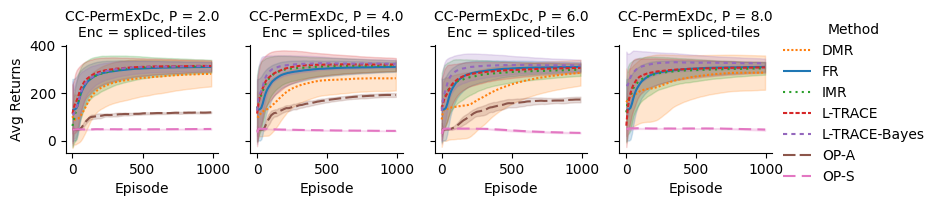

In [22]:
plot_eval_result(
    env="Finite-CC-PermExDc-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa",
)

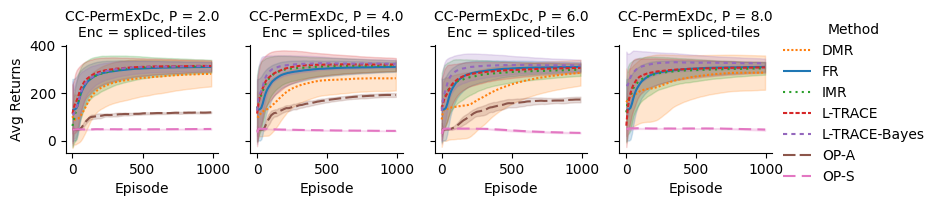

In [23]:
plot_eval_result(
    env="Finite-CC-PermExDc-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

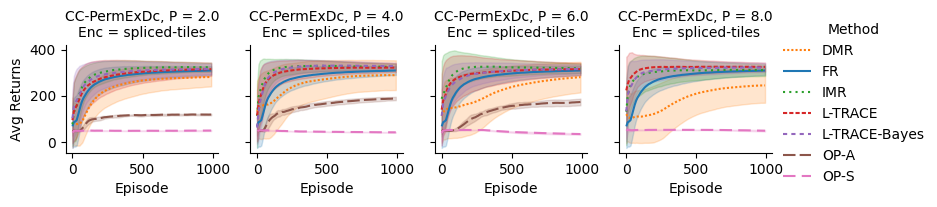

In [24]:
plot_eval_result(
    env="Finite-CC-PermExDc-v0",
    gamma=0.99,
    df_data=df_returns_curves,
    suffix="sarsa"
)

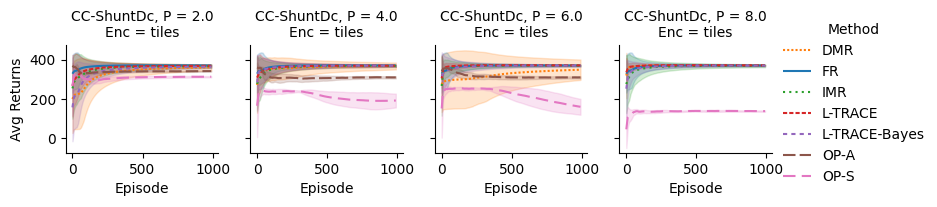

In [25]:
plot_eval_result(
    env="Finite-CC-ShuntDc-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

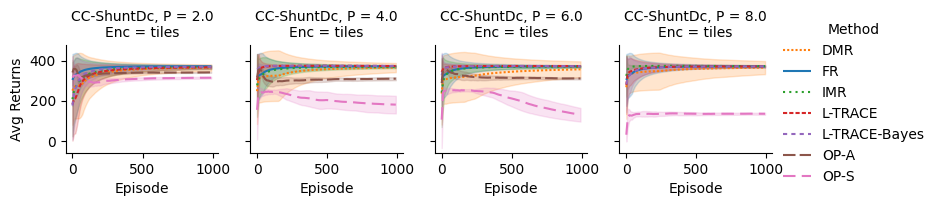

In [26]:
plot_eval_result(
    env="Finite-CC-ShuntDc-v0",
    gamma=0.99,
    df_data=df_returns_curves,
    suffix="sarsa"
)

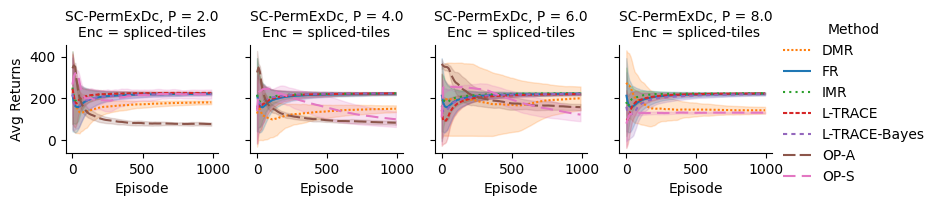

In [27]:
plot_eval_result(
    env="Finite-SC-PermExDc-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

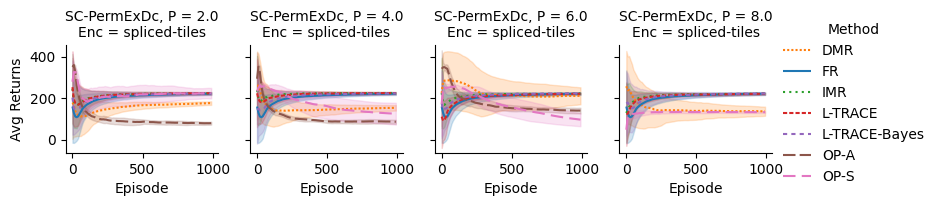

In [28]:
plot_eval_result(
    env="Finite-SC-PermExDc-v0",
    gamma=0.99,
    df_data=df_returns_curves,
    suffix="sarsa"
)

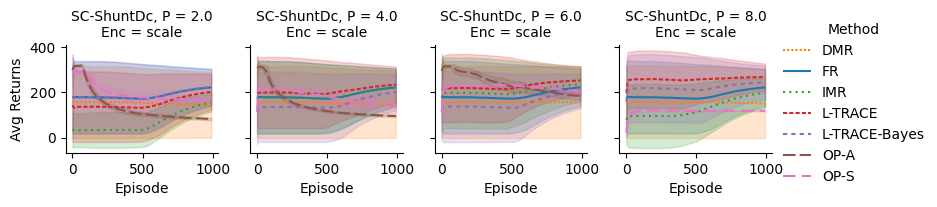

In [29]:
plot_eval_result(
    env="Finite-SC-ShuntDc-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

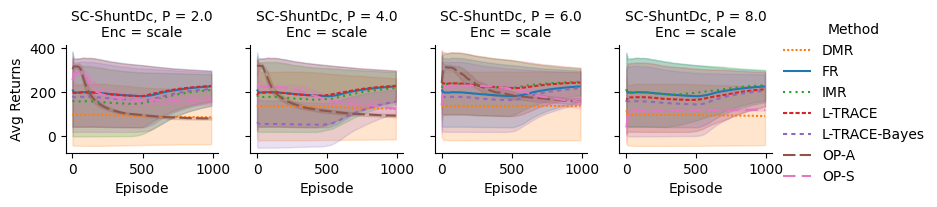

In [30]:
plot_eval_result(
    env="Finite-SC-ShuntDc-v0",
    gamma=0.99,
    df_data=df_returns_curves,
    suffix="sarsa"
)

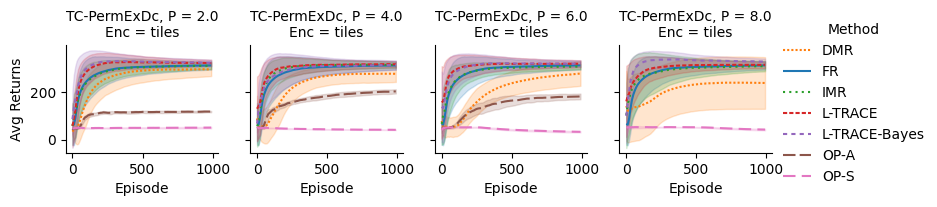

In [31]:
plot_eval_result(
    env="Finite-TC-PermExDc-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

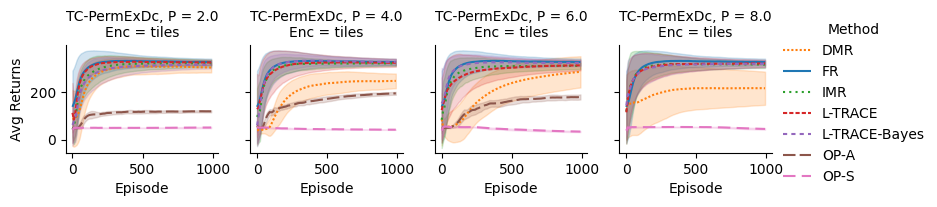

In [32]:
plot_eval_result(
    env="Finite-TC-PermExDc-v0",
    gamma=0.99,
    df_data=df_returns_curves,
    suffix="sarsa"
)

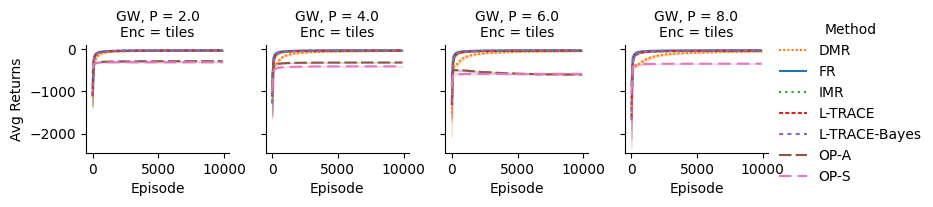

In [33]:
plot_eval_result(
    env="GridWorld-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

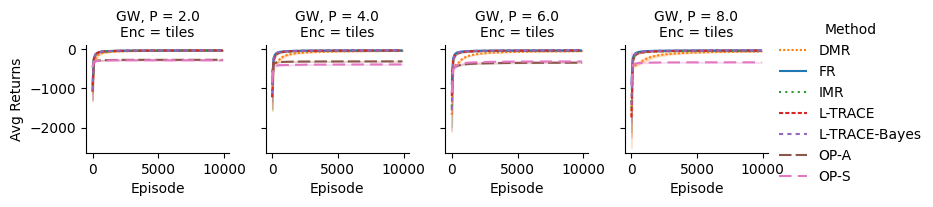

In [34]:
plot_eval_result(
    env="GridWorld-v0",
    gamma=0.99,
    df_data=df_returns_curves,
    suffix="sarsa"
)

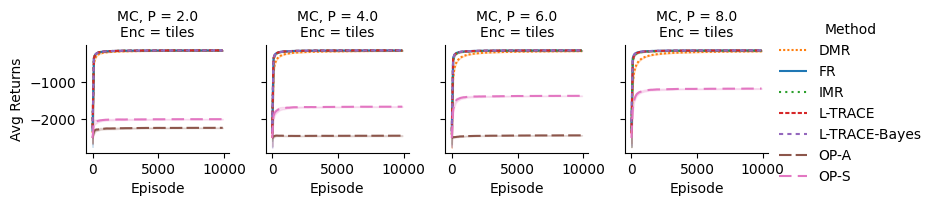

In [35]:
plot_eval_result(
    env="MountainCar-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

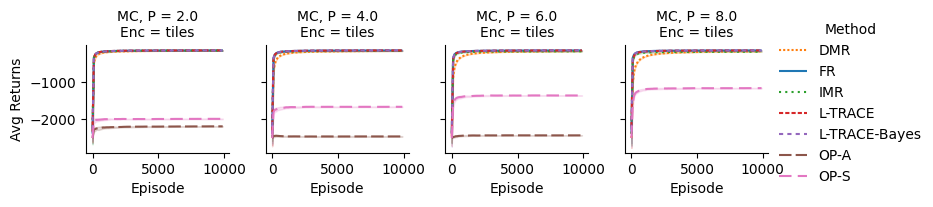

In [36]:
plot_eval_result(
    env="MountainCar-v0",
    gamma=0.99,
    df_data=df_returns_curves,
    suffix="sarsa"
)

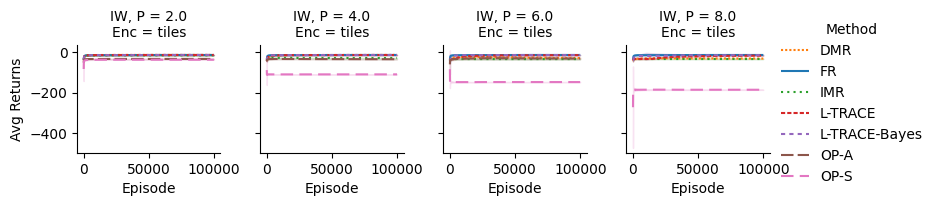

In [37]:
plot_eval_result(
    env="IceWorld-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

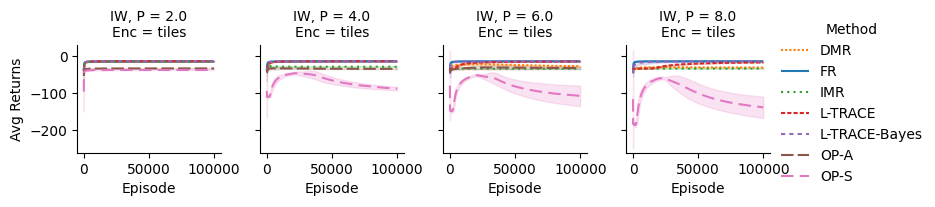

In [38]:
plot_eval_result(
    env="IceWorld-v0",
    gamma=0.99,
    df_data=df_returns_curves,
    suffix="sarsa"
)

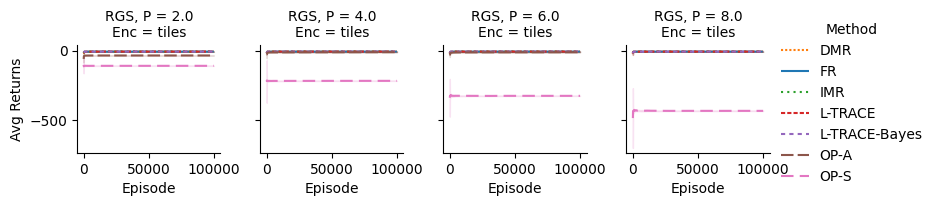

In [39]:
plot_eval_result(
    env="RedGreen-v0",
    gamma=1.0,
    df_data=df_returns_curves,
    suffix="sarsa"
)

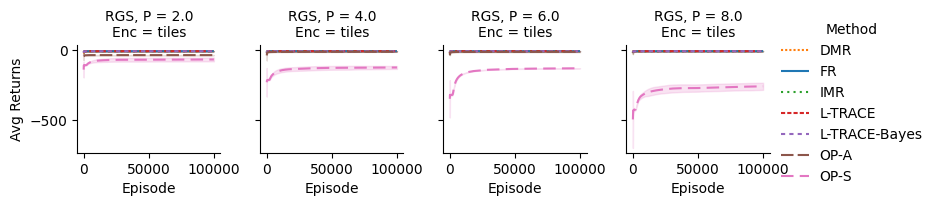

In [40]:
plot_eval_result(
    env="RedGreen-v0",
    gamma=0.99,
    df_data=df_returns_curves,
    suffix="sarsa"
)